# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-16 15:25:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [               <=>  ] 201.24M  58.7MB/s    in 3.8s    

2023-10-16 15:25:48 (53.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
set_random_seed(42)

In [9]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Разобьём обучающую выборку на обучющую-обучающую и обучающую-валидационную в соотношении 7 к 3 для подбора гиперпараметра альфа.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [10]:
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [11]:
alphas = np.logspace(-4, 1, 50)
train_rmses = []
val_rmses = []
for i in alphas:
  model = Ridge(alpha= i)
  model.fit(X_train_small, y_train_small)
  train_rmses.append(mean_squared_error(model.predict(X_train_small), y_train_small, squared=False))
  val_rmses.append(mean_squared_error(model.predict(X_val), y_val, squared=False))

In [12]:
minimal_val_rmse = min(val_rmses)
minimal_val_rmse_id = val_rmses.index(minimal_val_rmse)
a = alphas[minimal_val_rmse_id]
a

10.0

In [13]:
model_final = Ridge(alpha=a)
model_final.fit(X_train, y_train)
rmse_for_model = mean_squared_error(model_final.predict(X_test), y_test, squared=False)
rmse_for_model

9.510161842816515

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [14]:
mean = np.full(y_test.shape, np.mean(y_train))

In [15]:
best_rmse_metric = mean_squared_error(mean, y_test, squared=False)
best_rmse_metric

10.85246390513634

Попробуем то же самое но с помощью RidgeCV:

In [16]:
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)
mean_squared_error(clf.predict(X_test), y_test, squared=False)

9.510161842814659

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

In [12]:
X_train = torch.tensor(X_train).clone().detach().float()
y_train = torch.tensor(y_train).clone().detach().float()

X_test = torch.tensor(X_test).clone().detach().float()
y_test = torch.tensor(y_test).clone().detach().float()

In [19]:
set_random_seed(42)
model = nn.Linear(X_train.shape[1], 1)
train_batch = DataLoader(TensorDataset(X_train, y_train), batch_size= 35, shuffle = True)
test_batch = DataLoader(TensorDataset(X_test, y_test), batch_size= 35, shuffle = False)


for epoch in range(10):
  for batch, y_batch in tqdm(train_batch):
    predicted = model(batch)
    error = torch.mean((y_batch - predicted)**2)
    error.backward()

    model.weight.data = model.weight.data - 0.05 * model.weight.grad
    model.bias.data = model.bias.data - 0.05 * model.bias.grad
    model.weight.grad.data.zero_()
    model.bias.grad.data.zero_()

  with torch.no_grad():
    mse_train = []
    mse_test = []
    current_mse_test = []
    current_mse_train = []
    for x_test, test_target in test_batch:
      test_prediction = model(x_test)
      test_error = torch.sqrt(torch.mean((test_target - test_prediction)**2))
      current_mse_test.append(float(test_error))
    mse_test.append(np.mean(current_mse_test))

    for x_train, train_target in train_batch:
      train_prediction = model(x_train)
      train_error = torch.sqrt(torch.mean((train_target - train_prediction)**2))
      current_mse_train.append(float(train_error))
    mse_train.append(np.mean(current_mse_train))

  print(f"Epoch {epoch + 1}: test error {np.mean(mse_test)}, train {np.mean(mse_train)}")

  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 1: test error 9.884110592891208, train 11.041995056260891


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 2: test error 9.843837477690805, train 11.011880593656532


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 3: test error 9.773870239538516, train 10.981235319331555


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 4: test error 9.73028956596801, train 10.961266085338657


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 5: test error 9.699821910606435, train 10.947106074516913


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 6: test error 9.674552938894212, train 10.934496898153897


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 7: test error 9.656494458832439, train 10.923576505986066


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 8: test error 9.64266596260673, train 10.914748700462052


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 9: test error 9.62983574831407, train 10.907209337947492


  0%|          | 0/13249 [00:00<?, ?it/s]

Epoch 10: test error 9.621157960411658, train 10.902362198239093


In [20]:
import matplotlib.pyplot as plt

def draw_plot(final_test, final_train, num_epochs):
  plt.figure(figsize=(10, 7))
  plt.plot(np.arange(num_epochs), final_train, label='Train MSE', color ='r')
  plt.plot(np.arange(num_epochs), final_test, label='Test MSE', color ='b')
  plt.xlabel('Iteration')
  plt.ylabel('RMSE')
  plt.title('RMSE for gradient descent')
  plt.legend()
  plt.grid()

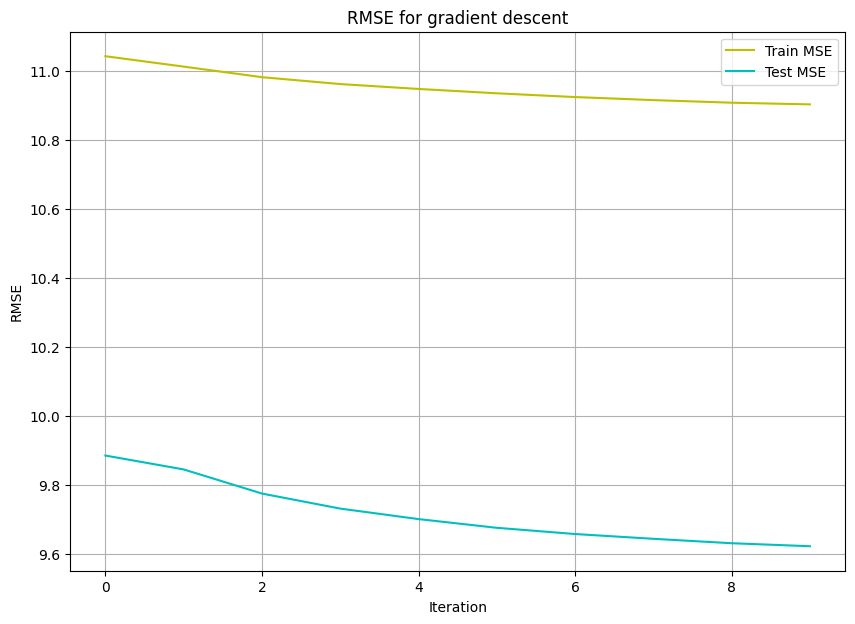

In [21]:
draw_plot(mse_test, mse_train, 10)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [13]:
y_train_reshaped = np.array(y_train).reshape(-1, 1)
y_test_reshaped = np.array(y_test).reshape(-1, 1)

y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

y_train = torch.tensor(y_train_reshaped).clone().detach().float()
y_train_scaled = torch.tensor(y_train_scaled).clone().detach().float()

y_test = torch.tensor(y_test_reshaped).clone().detach().float()
y_test_scaled = torch.tensor(y_test_scaled).clone().detach().float()

In [28]:
set_random_seed(42)
train_set = TensorDataset(X_train, y_train_scaled)
train_loader = DataLoader(train_set, batch_size=64, shuffle = True)

test_set = TensorDataset(X_test, y_test_scaled)
test_loader = DataLoader(test_set, batch_size=64, shuffle = False)

In [31]:
def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    with torch.no_grad():
        predicted = model(X_test)


    return predicted

In [32]:
set_random_seed(42)
def train(model, optimizer, criterion, scheduler, train_loader, test_loader, num_epochs):

  for epoch in range(num_epochs):
    for x, y in tqdm(train_loader):
      y_pred = model(x)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    with torch.no_grad():
      train_epoch_loss = []
      train_loss = []
      test_epoch_loss = []
      test_loss = []

      for x, y in train_loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        train_epoch_loss.append(torch.sqrt(loss))
      train_loss.append(np.mean(train_epoch_loss))

      for x, y in test_loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_epoch_loss.append(torch.sqrt(loss))
      test_loss.append(np.mean(test_epoch_loss))

      predictions = test(model, criterion, test_set)
      rmse_test = mean_squared_error(scaler.inverse_transform(predictions.detach().numpy().reshape(-1, 1)), y_test.numpy(), squared=False)
      scheduler.step()
      print(scheduler.get_last_lr())
      print(f'Epoch {epoch + 1}: test loss inverse transformed {rmse_test}')
      print(f'Epoch {epoch + 1}: test loss {np.mean(test_epoch_loss)}, train loss {np.mean(train_epoch_loss)}')

  draw_plot(test_loss, train_loss, num_epochs)

In [37]:
set_random_seed(42)
model = nn.Sequential(
    nn.Linear(90, 180),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(180, 240),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(240, 360),
    nn.Dropout(0.4),
    nn.ReLU(),
    nn.Linear(360, 1)
    )

optimizer = torch.optim.SGD(model.parameters(), lr = 6e-3) #6e-3 дает 8.79 на 4 слоях 5е-3 8.79 на 10 эпохе
scheduler_func = lambda epoch: 1**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda= scheduler_func)
criterion = nn.MSELoss()
train(model, optimizer, criterion, scheduler, train_loader, test_loader, 19)

  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 1: test loss inverse transformed 9.175981521606445
Epoch 1: test loss 0.758756697177887, train loss 0.8251603841781616


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 2: test loss inverse transformed 9.036118507385254
Epoch 2: test loss 0.7378174066543579, train loss 0.8071182370185852


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 3: test loss inverse transformed 8.98237419128418
Epoch 3: test loss 0.7380699515342712, train loss 0.7987827062606812


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 4: test loss inverse transformed 8.950591087341309
Epoch 4: test loss 0.7365838885307312, train loss 0.7941219806671143


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 5: test loss inverse transformed 8.932418823242188
Epoch 5: test loss 0.7363654971122742, train loss 0.7903568744659424


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 6: test loss inverse transformed 8.90637493133545
Epoch 6: test loss 0.7282117605209351, train loss 0.7859144806861877


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 7: test loss inverse transformed 8.890347480773926
Epoch 7: test loss 0.7287314534187317, train loss 0.7831021547317505


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 8: test loss inverse transformed 8.915922164916992
Epoch 8: test loss 0.7300816178321838, train loss 0.7803040146827698


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 9: test loss inverse transformed 8.88724422454834
Epoch 9: test loss 0.7275228500366211, train loss 0.7768635749816895


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 10: test loss inverse transformed 8.871803283691406
Epoch 10: test loss 0.7214315533638, train loss 0.7749101519584656


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 11: test loss inverse transformed 8.873449325561523
Epoch 11: test loss 0.721164345741272, train loss 0.7724656462669373


  0%|          | 0/7246 [00:00<?, ?it/s]

[0.006]
Epoch 12: test loss inverse transformed 8.856664657592773
Epoch 12: test loss 0.7248446941375732, train loss 0.7697828412055969


  0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
set_random_seed(42)
model = model = nn.Sequential(
    nn.Linear(90, 180),
    nn.ReLU(),
    nn.Linear(180, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 1))

optimizer = torch.optim.SGD(model.parameters(), lr=6e-5)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.05)
criterion = nn.MSELoss()
train(model, optimizer, criterion, scheduler, train_loader, test_loader, 18)

In [ ]:
assert len(test(model, criterion, test_loader)) == y_test.shape[0]

In [ ]:
set_random_seed(42)

predictions = test(model, criterion, test_set)
RMSE = mean_squared_error(scaler.inverse_transform(predictions.reshape(-1, 1)), y_test, squared=False)

print(f'RMSE: {RMSE}')

Это перебор параметров: не включайте, убьёт

In [ ]:
set_random_seed(42)
lrs = np.logspace(-5, -1, 10)
results = []
for i in lrs:
  train_set = TensorDataset(X_train, y_train_scaled)
  train_loader = DataLoader(train_set, batch_size=128, shuffle = True, pin_memory = True)

  test_set = TensorDataset(X_test, y_test_scaled)
  test_loader = DataLoader(test_set, batch_size=128, shuffle = False, pin_memory = True)
  model = nn.Sequential(
    nn.Linear(90, 180),
    nn.ReLU(),
    nn.Linear(180, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 1))
  optimizer = torch.optim.Adam(model.parameters(), lr=i)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)
  criterion = nn.MSELoss()
  train(model, optimizer, criterion, scheduler, train_loader, test_loader, 16)
  predictions = test(model, criterion, test_set)
  results.append(mean_squared_error(scaler.inverse_transform(predictions.reshape(-1, 1)), y_test, squared=False))

In [ ]:
np.logspace(-6, -1, 10)[results.index(min(results))]

In [ ]:
set_random_seed(42)
gammas = np.linspace(0.1, 0.5, 10)
results = []
for i in gammas:
  train_set = TensorDataset(X_train, y_train_scaled)
  train_loader = DataLoader(train_set, batch_size=128, shuffle = True, pin_memory = True)

  test_set = TensorDataset(X_test, y_test_scaled)
  test_loader = DataLoader(test_set, batch_size=128, shuffle = False, pin_memory = True)
  model = nn.Sequential(
    nn.Linear(90, 180),
    nn.ReLU(),
    nn.Linear(180, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 1))
  optimizer = torch.optim.Adam(model.parameters(), lr= 0.000059)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=i)
  criterion = nn.MSELoss()
  train(model, optimizer, criterion, scheduler, train_loader, test_loader, 16)
  predictions = test(model, criterion, test_set)
  results.append(mean_squared_error(scaler.inverse_transform(predictions.reshape(-1, 1)), y_test, squared=False))

In [ ]:
np.linspace(0.1, 0.5, 10)[results.index(min(results))]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Итак, в задании 0 я увидела, что простая гребневая регрессия даёт весьма неплохое качество, значит, у нас нет поводов накручивать большое количество слоёв. Я начала с двух слоёв (90, 180) (180, 1) и простого ReLU между ними - качество получилось 9.17. Решила оставить слои как есть и поиграться с алгоритмом оптимизации - попробовала SGD, перебрала шаги, чтобы найти оптимальный, оптимальным при такой архитектуре был 0.0002 с копейками. Качество не улучшилось, решила поставить scheduler - перебрала несколько - StepLR, перебрала гаммы, нашла оптимальную при оптимальном шаге - качество 8.9. Плохо - попробовала изменить алгоритм на Adam при тех же двух слоях - качество стало чуть лучше - около 8.85. Добавила ещё один слой. Качество 8.83. Дальше долго подбирала число входов и выходов - качество оставалось примерно таким же, добавила ещё слои. Получились слои (90, 180) (180, 60) (60, 30) (30, 1). Выбилось качество 8.786. Начала пробовать Dropout и BatchNorm, обучалось очень долго, а качество падало, колебалось около 8.9. Руководствовалась такой логикой: трейн падает, тест растёт -> увеличиваю дропаут, тест начинает скакать в середине цикла -> уменьшаю гамму. Уменьшала шаг ещё сильнее, уже на глаз, перебор циклом с такой архитектурой работал очень долго. Проверяла с разным количеством эпох, качество не росло. Попоробовала разные scheduler - через лямбду 0.975**epoch и другие функции, пробовала даже косинус. Вернулась к StepLR, пропробовала с каждым слоем наращивать количество outputoв, переобучалось, ставила dropout - чем больше выходов, тем больше вероятность. Была архитектура типа (90, 180) Dropout(0.1) (180, 250) Dropout(0.3) (250, 360) Dropout(0.4) (360, 1). И много других комбинаций - не помогало. Качество 8.78 так и не перебивалось. Вспомнила, что не трогала размеры батчей - поперебирала - 35, 56, 64, 128, 256. На 256 при прочих равных работало ощутимо хуже, как и на 35. С семинаров помню, что у Adam+scheduler красивее всего градиентный спуск, решила больше не метаться и не менять метод оптимизации. Час до дедлайна вернулась к архитектуре, которая давала качество 8.78.